In [1]:
# !pip install transformers
# !pip install sentencepiece
# !pip install huggingface_hub
# !apt install libomp-dev
# !pip install faiss-gpu

In this work I will implement triplet loss approach for intent classification. Intent classification problem is very common in dialogue systems, because there can be a great amount of intet classes, each carrying its own system responce behaviour. 

Metric learning seems like a legit approach to this problem, because there can be numerous number of intent classes with imbalanced number of samples and we want to build such system, where we can fastly retrain our model with new samples. Also we would not want to overfit our model to a certain set of samples, instead we want to learn a metric which would be able to distinguish between different classes.


We can do it by learning a non linear function $F$ which will take an input vector $x \in R^m$, transform it in a new vector $x^* \in R^n$, where usually $n < m$. This function will transform vectors from $R^m$ in $R^n$ space in a such way that classes from one class will lie near each other and different classes will lie far away from each other. After this transformation we can use simple metric algorithms such as KNN in order to do classification.

We will be using triplet loss function with random sampling in order to learn desired fucntion capability.

This work is inspired by a Facebook paper - https://arxiv.org/abs/1503.03832


*As our base embeddings we will be using Hugging Face BERT-bert embeddings. The training will be conducted on GPU*

In [2]:
dev

'cuda:1'

In [3]:
import numpy as np
from sklearn.metrics import classification_report
import torch
from torch import optim
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE
from transformers import BertModel, BertTokenizer
from transformers import AutoModel, AutoTokenizer
import sys
import os

sys.path.append(os.path.join(os.getcwd(), "./src"))

torch.manual_seed(42)
np.random.seed(42)

warnings.filterwarnings('ignore')

if torch.cuda.is_available():  
  dev = "cuda" 
else:  
  dev = "cpu"  
DEVICE = torch.device(dev)  
MODEL_NAME = 'prajjwal1/bert-tiny'
FROZEN_BERT = AutoModel.from_pretrained(MODEL_NAME).to(DEVICE)
TOKENIZER = AutoTokenizer.from_pretrained(MODEL_NAME)
MAX_LEN = 128

%load_ext autoreload
%autoreload 2

from src.utils.data import split_by_classes, validate_splits, load_dataframe
from src.utils.encoding import encode_data, create_tranformer_input
from src.utils.tsne import get_indexes_of_samples
from src.utils.triplets import TripletGenerator
from src.models.knn import KnnIndex
from src.models.metricbert import TransformerBasedEncoder
from src.losses.losses import compute_triplet_loss, l2_distance, compute_silhouette_score

%matplotlib inline

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


The training, validation and test set I wiil be using OOS classification dataset. It contains 3 types of dataset - full, imbalanced and small datasets. Since I want to mimic the intent classification problem which occures a lot in dialogue systems - class imbalance, so I will be using imbalaced OOS dataset.
The paper for dataset - https://www.aclweb.org/anthology/D19-1131.pdf

In [4]:
!git clone https://github.com/clinc/oos-eval.git

Cloning into 'oos-eval'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 69 (delta 16), reused 16 (delta 16), pack-reused 50
Unpacking objects: 100% (69/69), 1.74 MiB | 3.44 MiB/s, done.


In [5]:
total_df = load_dataframe("./oos-eval/data/data_full.json")

print("Total size: ", total_df.shape)
total_df.head()

Total size:  (23700, 2)


,intents,targets
0,set a warning for when my bank account starts ...,oos
1,a show on broadway,oos
2,who has the best record in the nfl,oos
3,how do i find the area of a circle,oos
4,how many onions do i have on hand,oos


We will split files in following fashion - 60% classes to train, 20% to dev, 20% to test.

<Axes: >

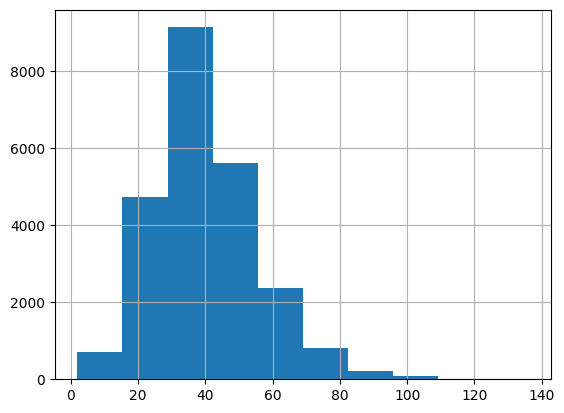

In [6]:
total_df['intents'].apply(lambda x: len(x)).hist()

In [7]:
splits = split_by_classes(total_df, train_classes_ratio=0.6, seed=42)

# Validate splits are correct
validate_splits(splits)

# Retrieve data
train_df = splits['train_df']
val_df = splits['val_df']
test_df = splits['test_df']
seen_test_df = splits['seen_test_df']
unseen_test_df = splits['unseen_test_df']

Here I will prepare data for input into BERT-base model. We will tokenize, pad it and mask padded symbols in order not to confuse BERT.

In [8]:
a = encode_data(
    text_samples=["hi, hi"],
    bert_encoder=FROZEN_BERT,
    tokenizer=TOKENIZER,
    device=DEVICE,
    max_length=MAX_LEN,
    batch_size=1,
    verbose=True
)
a

Encoding data: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.13s/it]


tensor([[-1.0000,  0.0954, -0.9998, -0.1484, -0.9987,  0.0395, -0.9024, -0.7759,
          0.1011, -0.1367, -0.0615, -0.0737, -0.0957,  1.0000, -0.7149, -0.9522,
          0.9167,  0.0297, -0.9380,  0.4773,  0.9477,  0.0867,  0.8234,  0.0820,
         -0.9994, -0.0366, -1.0000,  0.7606,  0.9693,  0.0870, -0.1553,  0.0164,
         -0.9779,  0.1899,  0.3455,  0.9996, -0.9802, -0.1409,  0.9448, -0.9978,
          0.9884,  0.9894, -0.9963,  0.9424, -1.0000, -0.1692, -0.9956,  0.9995,
          0.9879,  0.9992,  0.4721, -0.6137, -0.0702,  0.8798,  0.9488,  0.9996,
         -0.9805, -0.9097,  0.8818,  0.3947, -0.0350,  0.8928, -0.9201,  0.9858,
         -0.9753, -1.0000, -0.6335,  0.9427,  0.9429,  0.9906,  0.9998,  0.1567,
         -0.9949,  0.0692,  0.9166, -0.9919, -0.8721,  0.2623, -0.6275,  0.1306,
          0.6182, -0.1282, -0.9720, -0.9998,  0.9998, -0.9895, -0.6618, -0.8513,
         -0.2280,  0.4325, -0.9217,  0.9896, -0.9421,  0.8690,  0.5628,  0.2250,
         -0.7019,  0.9785, -

In [9]:
common_kwargs = {
    "bert_encoder": FROZEN_BERT,
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
    "batch_size": 256,
    "verbose": True,
}

train_embeddings = encode_data(train_df["intents"].to_list(), **common_kwargs)
val_embeddings = encode_data(val_df["intents"].to_list(), **common_kwargs)
seen_test_embeddings = encode_data(seen_test_df["intents"].to_list(), **common_kwargs)
unseen_test_embeddings = encode_data(unseen_test_df["intents"].to_list(), **common_kwargs)

print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Val embeddings shape: {val_embeddings.shape}")
print(f"Seen test embeddings shape: {seen_test_embeddings.shape}")
print(f"Unseen test embeddings shape: {unseen_test_embeddings.shape}")

Encoding data: 57it [00:00, 85.14it/s]                                                                                                                                                                                                  
Encoding data: 18it [00:00, 625.49it/s]                                                                                                                                                                                                 
Encoding data: 10it [00:00, 598.16it/s]                                                                                                                                                                                                 
Encoding data: 10it [00:00, 584.15it/s]                                                                                                                                                                                                 

Train embeddings shape: torch.Size([14550, 128])
Val embeddings shape: torch.Size([4500, 128])
Seen test embeddings shape: torch.Size([2325, 128])
Unseen test embeddings shape: torch.Size([2325, 128])


Lets look at the embeddigns that we have in TSNE.

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


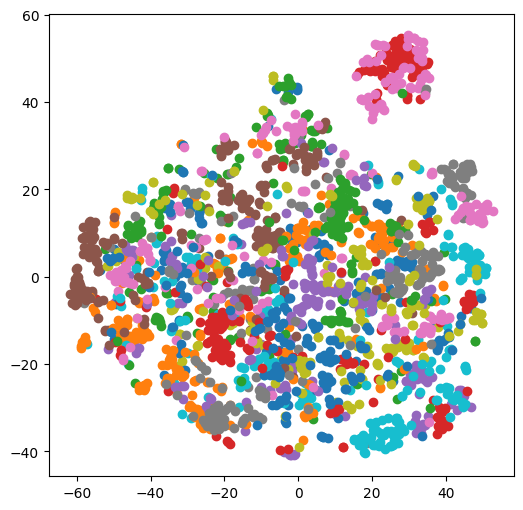

In [10]:
# %%time
tsne = TSNE()
tsne_original_val_emb = tsne.fit_transform(unseen_test_embeddings.detach().cpu())
val_classes_indexes = get_indexes_of_samples(unseen_test_df["targets"].values)

plt.figure(figsize=(6, 6))
for key, val in val_classes_indexes.items():
    plt.scatter(
        x=tsne_original_val_emb[val, 0], y=tsne_original_val_emb[val, 1], label=key
    )

### Baseline model



In [11]:
# Prepare embeddings to build KNN Space

storage_embeddings = np.concatenate(
    [
        train_embeddings.cpu().detach().numpy(),
        val_embeddings.cpu().detach().numpy(),
        seen_test_embeddings.cpu().detach().numpy(),
    ],
    axis=0,
)
classes_array = (
    train_df["targets"].to_list()
    + val_df["targets"].to_list()
    + seen_test_df["targets"].to_list()
)

print(f'storage embeddings shape: {storage_embeddings.shape}\nclasses length: {len(classes_array)}')

storage embeddings shape: (21375, 128)
classes length: 21375


In [12]:
# Let's test how KnnIndex works

knn_index = KnnIndex(storage_embeddings, classes_array)
vectorized_query = encode_data(["how old are you"], **common_kwargs).cpu().detach().numpy()
knn_index.search_index(vectorized_query)

Encoding data: 1it [00:00, 399.34it/s]


'how_old_are_you'

In [13]:
# Try to classify intents with KnnIndex on Bert embeddings

preds = []
test_intents = set(unseen_test_df["targets"].to_list())

vectorized_queries = (
    encode_data(unseen_test_df["intents"].to_list(), **common_kwargs)
    .cpu()
    .detach()
    .numpy()
)
for query in tqdm(vectorized_queries, desc="Predicting"):
    pred_class = knn_index.search_index(np.expand_dims(query, axis=0))
    if pred_class in test_intents:
        preds.append(pred_class)
    else:
        preds.append("misclassified")


print(classification_report(preds, unseen_test_df['targets'].tolist()))

Encoding data: 10it [00:00, 627.31it/s]                                                                                                                                                                                                 
Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2325/2325 [00:06<00:00, 333.89it/s]

                         precision    recall  f1-score   support

     application_status       0.41      0.94      0.57        32
             car_rental       0.33      0.93      0.49        29
          card_declined       0.69      0.95      0.80        57
               carry_on       0.45      0.97      0.62        39
          change_accent       0.60      0.98      0.74        53
        change_language       0.43      0.92      0.58        36
           credit_limit       0.37      0.94      0.53        32
           credit_score       0.54      0.90      0.68        48
               distance       0.29      0.76      0.42        25
                    gas       0.41      0.84      0.55        31
                goodbye       0.42      0.92      0.58        36
                 income       0.30      0.84      0.44        25
ingredient_substitution       0.62      0.94      0.75        50
     international_visa       0.76      0.95      0.84        60
                  maybe 

### Metric learning approach

In order to sample easily, I will form dict of classes with samples indexes for each class.

In [14]:
train_target_indexes_dict = get_indexes_of_samples(train_df['targets'].to_list())

print('Train Target types: ', train_target_indexes_dict.keys())
print('Train Number of classes: ', len(train_target_indexes_dict.keys()))

Train Target types:  dict_keys(['insurance_change', 'repeat', 'change_ai_name', 'cancel', 'roll_dice', 'smart_home', 'tire_change', 'apr', 'current_location', 'insurance', 'order', 'no', 'food_last', 'reminder_update', 'taxes', 'rewards_balance', 'order_status', 'replacement_card_duration', 'vaccines', 'meaning_of_life', 'find_phone', 'flight_status', 'payday', 'international_fees', 'who_made_you', 'report_lost_card', 'text', 'damaged_card', 'todo_list_update', 'calculator', 'date', 'directions', 'book_hotel', 'are_you_a_bot', 'improve_credit_score', 'change_user_name', 'new_card', 'expiration_date', 'calories', 'ingredients_list', 'timezone', 'pto_request_status', 'travel_suggestion', 'whisper_mode', 'user_name', 'book_flight', 'tell_joke', 'tire_pressure', 'order_checks', 'do_you_have_pets', 'transactions', 'where_are_you_from', 'flip_coin', 'oil_change_when', 'rollover_401k', 'interest_rate', 'pto_request', 'who_do_you_work_for', 'fun_fact', 'bill_balance', 'update_playlist', 'pay_b

In [15]:
val_target_indexes_dict = get_indexes_of_samples(val_df['targets'].to_list())

print('Val Target types: ', val_target_indexes_dict.keys())
print('Val Number of classes: ', len(val_target_indexes_dict.keys()))

Val Target types:  dict_keys(['cook_time', 'credit_limit_change', 'definition', 'weather', 'nutrition_info', 'plug_type', 'meeting_schedule', 'reminder', 'oil_change_how', 'measurement_conversion', 'make_call', 'shopping_list', 'exchange_rate', 'account_blocked', 'travel_notification', 'how_old_are_you', 'reset_settings', 'meal_suggestion', 'restaurant_reviews', 'what_is_your_name', 'thank_you', 'traffic', 'report_fraud', 'translate', 'spending_history', 'how_busy', 'min_payment', 'what_song', 'redeem_rewards', 'accept_reservations'])
Val Number of classes:  30


In [16]:
tr_input_common_params = {
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
}

train_token_ids_array, train_attention_mask_array = create_tranformer_input(
    train_df["intents"].to_list(), **tr_input_common_params
)
val_token_ids_array, val_attention_mask_array = create_tranformer_input(
    val_df["intents"].to_list(), **tr_input_common_params
)
train_token_ids_array.shape, val_token_ids_array.shape

(torch.Size([14550, 128]), torch.Size([4500, 128]))

The main key point in metric learning is sampling strategy. Here I will implement random sampling strategy. 

Random sampling strategy simply gets random sample from other classes excluding the anchor class.

In [17]:
train_triplet_generator = TripletGenerator(
    class2idx_dict=train_target_indexes_dict,
    token_ids_storage=train_token_ids_array,
    attention_storage=train_attention_mask_array,
)

example_batch = train_triplet_generator(n_triplets=2)
example_batch["anchor"]["token_ids"].shape, example_batch["negative"]["token_ids"].shape

(torch.Size([2, 128]), torch.Size([2, 128]))

In this work I am using custom loss function - triplet loss function. As a distance metric I will be using l2 distance.

In [18]:
a = torch.Tensor([[1, 1], [3, 4]]).to(DEVICE)
pos = torch.Tensor([[2, 3], [5, 6]]).to(DEVICE)
neg = torch.Tensor([[1, 1], [1, 2]]).to(DEVICE)

print("Triplet loss result:", compute_triplet_loss(a, pos, neg, l2_distance, margin=0.2))

Triplet loss result: tensor(2.7000, device='cuda:0')


Here is presented the training of the dssm model for metric learning. As a validation metric I use recall - check if anchor to positive distance is less than anchor to negative for a given triplet.

I will be using l2 distance, because in current setting cos proved itself to be not so good.



In [19]:
# Additional Info when using cuda

if torch.device(DEVICE).type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_cached(0) / 1024**3, 1), "GB")

Tesla T4
Memory Usage:
Allocated: 0.1 GB
Cached:    0.4 GB


In [20]:
compute_silhouette_score(
    encoder=FROZEN_BERT,
    number_of_classes=10,
    target_indexes_dict=train_target_indexes_dict,
    token_ids_array=train_token_ids_array,
    attention_mask_array=train_attention_mask_array,
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 142.23it/s]


-0.062481157

In [ ]:
import sys
import os
sys.path.append(os.path.join(os.getcwd(), "./src"))

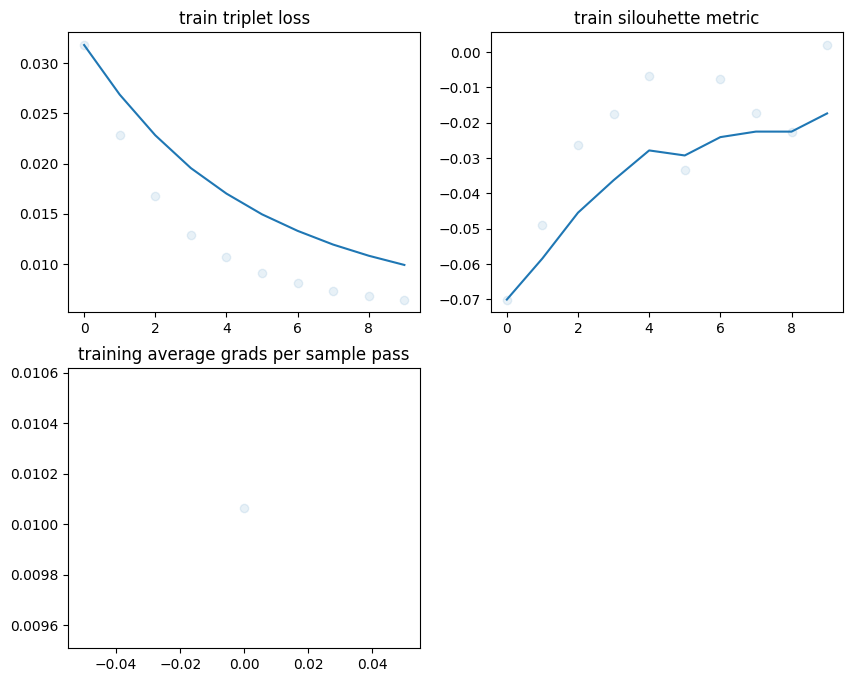

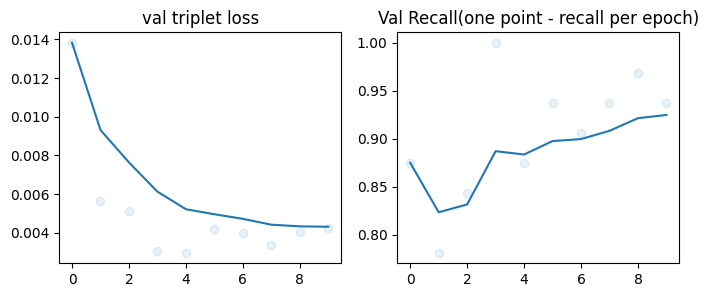

In [21]:
from src.loops.basic import fit


train_generator = TripletGenerator(
    train_target_indexes_dict,
    token_ids_storage=train_token_ids_array,
    attention_storage=train_attention_mask_array,
)

val_generator = TripletGenerator(
    val_target_indexes_dict,
    token_ids_storage=val_token_ids_array,
    attention_storage=val_attention_mask_array,
)

LAYERS2TRAIN = 0
# metric_bert = MetricBERT(FROZEN_BERT)
metric_bert = TransformerBasedEncoder(FROZEN_BERT, LAYERS2TRAIN)
optimizer = optim.Adam(metric_bert.parameters(), lr=2e-5)


fit(
    dataset_passes=10,
    batch_szie=128,
    train_epoch_steps=512,
    val_epoch_steps=32,
    triplet_margin=100,
    model=metric_bert,
    optimizer=optimizer,
    train_generator=train_generator,
    val_generator=val_generator,
    train_target_indexes_dict=train_target_indexes_dict,
    train_token_ids_array=train_token_ids_array,
    train_attention_mask_array=train_attention_mask_array,
)

In [24]:
encode_data(['hi'], FROZEN_BERT, tokenizer=TOKENIZER, device=DEVICE, max_length=MAX_LEN)[0][0]

Encoding data: 1it [00:00, 339.98it/s]


tensor(-1.0000, device='cuda:0')

In [25]:
encode_data(['hi'], metric_bert.bert, tokenizer=TOKENIZER, device=DEVICE, max_length=MAX_LEN)[0][0]

Encoding data: 1it [00:00, 414.74it/s]


tensor(-1.0000, device='cuda:0')

In [26]:
# Saving finetuned model

finetuned_bert_to_save = (
    metric_bert.bert.module if hasattr(metric_bert.bert, "module") else metric_bert.bert
)
finetuned_bert_to_save.save_pretrained("training_result/oos_finetuned_bert")

After we have seen that our loss moved to plateau, lets learn KNN classifier on top of the new learned embeddings.

In [27]:
new_common_kwargs = {
    "bert_encoder": metric_bert.bert,
    "tokenizer": TOKENIZER,
    "device": DEVICE,
    "max_length": MAX_LEN,
    "batch_size": 256,
    "verbose": True,
}

new_train_embeddings = encode_data(train_df["intents"].to_list(), **new_common_kwargs)
new_val_embeddings = encode_data(val_df["intents"].to_list(), **new_common_kwargs)
new_seen_test_embeddings = encode_data(
    seen_test_df["intents"].to_list(), **new_common_kwargs
)
new_unseen_test_embeddings = encode_data(
    unseen_test_df["intents"].to_list(), **new_common_kwargs
)

print(f"New Train shape: {new_train_embeddings.shape}")
print(f"New Val shape: {new_val_embeddings.shape}")
print(f"New Seen test shape: {new_seen_test_embeddings.shape}")
print(f"New Unseen test shape: {new_unseen_test_embeddings.shape}")

Encoding data: 57it [00:00, 88.17it/s]                                                                                                                                                                                                  
Encoding data: 18it [00:00, 629.44it/s]                                                                                                                                                                                                 
Encoding data: 10it [00:00, 629.97it/s]                                                                                                                                                                                                 
Encoding data: 10it [00:00, 593.36it/s]                                                                                                                                                                                                 

New Train shape: torch.Size([14550, 128])
New Val shape: torch.Size([4500, 128])
New Seen test shape: torch.Size([2325, 128])
New Unseen test shape: torch.Size([2325, 128])


In [28]:
# Prepare new embeddings from finetuned model

new_storage_embeddings = np.concatenate(
    [
        new_train_embeddings.cpu().detach().numpy(),
        new_val_embeddings.cpu().detach().numpy(),
        new_seen_test_embeddings.cpu().detach().numpy(),
    ],
    axis=0,
)
classes_array = (
    train_df["targets"].to_list()
    + val_df["targets"].to_list()
    + seen_test_df["targets"].to_list()
)
new_storage_embeddings.shape, len(classes_array)

((21375, 128), 21375)

In [29]:
# Initialize KNN & sanity check it

knn_index = KnnIndex(new_storage_embeddings, classes_array)
vectorized_query = encode_data(["how old are you"], **new_common_kwargs).cpu().detach().numpy()
knn_index.search_index(vectorized_query)

Encoding data: 1it [00:00, 367.57it/s]


'how_old_are_you'

In [30]:
# Try to classify intents with KnnIndex on Bert embeddings

preds = []
test_intents = set(unseen_test_df["targets"].to_list())

vectorized_queries = (
    encode_data(unseen_test_df["intents"].to_list(), **new_common_kwargs)
    .cpu()
    .detach()
    .numpy()
)
for query in tqdm(vectorized_queries, desc="Predicting"):
    pred_class = knn_index.search_index(np.expand_dims(query, axis=0))
    if pred_class in test_intents:
        preds.append(pred_class)
    else:
        preds.append("misclassified")

qual = classification_report(preds, unseen_test_df['targets'].tolist(), output_dict=True)

Encoding data: 10it [00:00, 627.56it/s]                                                                                                                                                                                                 
Predicting: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2325/2325 [00:06<00:00, 335.55it/s]


In [31]:
qual['weighted avg']

{'precision': 0.4772267553667916,
 'recall': 0.6468817204301075,
 'f1-score': 0.5418582884724195,
 'support': 2325}

In [32]:
qual.keys()

dict_keys(['application_status', 'car_rental', 'card_declined', 'carry_on', 'change_accent', 'change_language', 'credit_limit', 'credit_score', 'distance', 'gas', 'goodbye', 'income', 'ingredient_substitution', 'international_visa', 'maybe', 'misclassified', 'next_holiday', 'next_song', 'pin_change', 'play_music', 'pto_balance', 'pto_used', 'recipe', 'restaurant_reservation', 'restaurant_suggestion', 'share_location', 'sync_device', 'time', 'todo_list', 'travel_alert', 'uber', 'what_are_your_hobbies', 'accuracy', 'macro avg', 'weighted avg'])

In [33]:
old_encoded_test_data = encode_data(['Hi, my name is Oleg'], **common_kwargs)
new_encoded_test_data = encode_data(['Hi, my name is Oleg'], **new_common_kwargs)

print('frozen bert: ', old_encoded_test_data[0][:5])
print('finetuned bert: ', new_encoded_test_data[0][:5])

Encoding data: 1it [00:00, 397.19it/s]
Encoding data: 1it [00:00, 570.19it/s]

frozen bert:  tensor([-1.0000,  0.0111, -0.9996,  0.9239, -0.9984], device='cuda:0')
finetuned bert:  tensor([-1.0000, -0.1223, -1.0000,  0.9980, -0.9998], device='cuda:0')


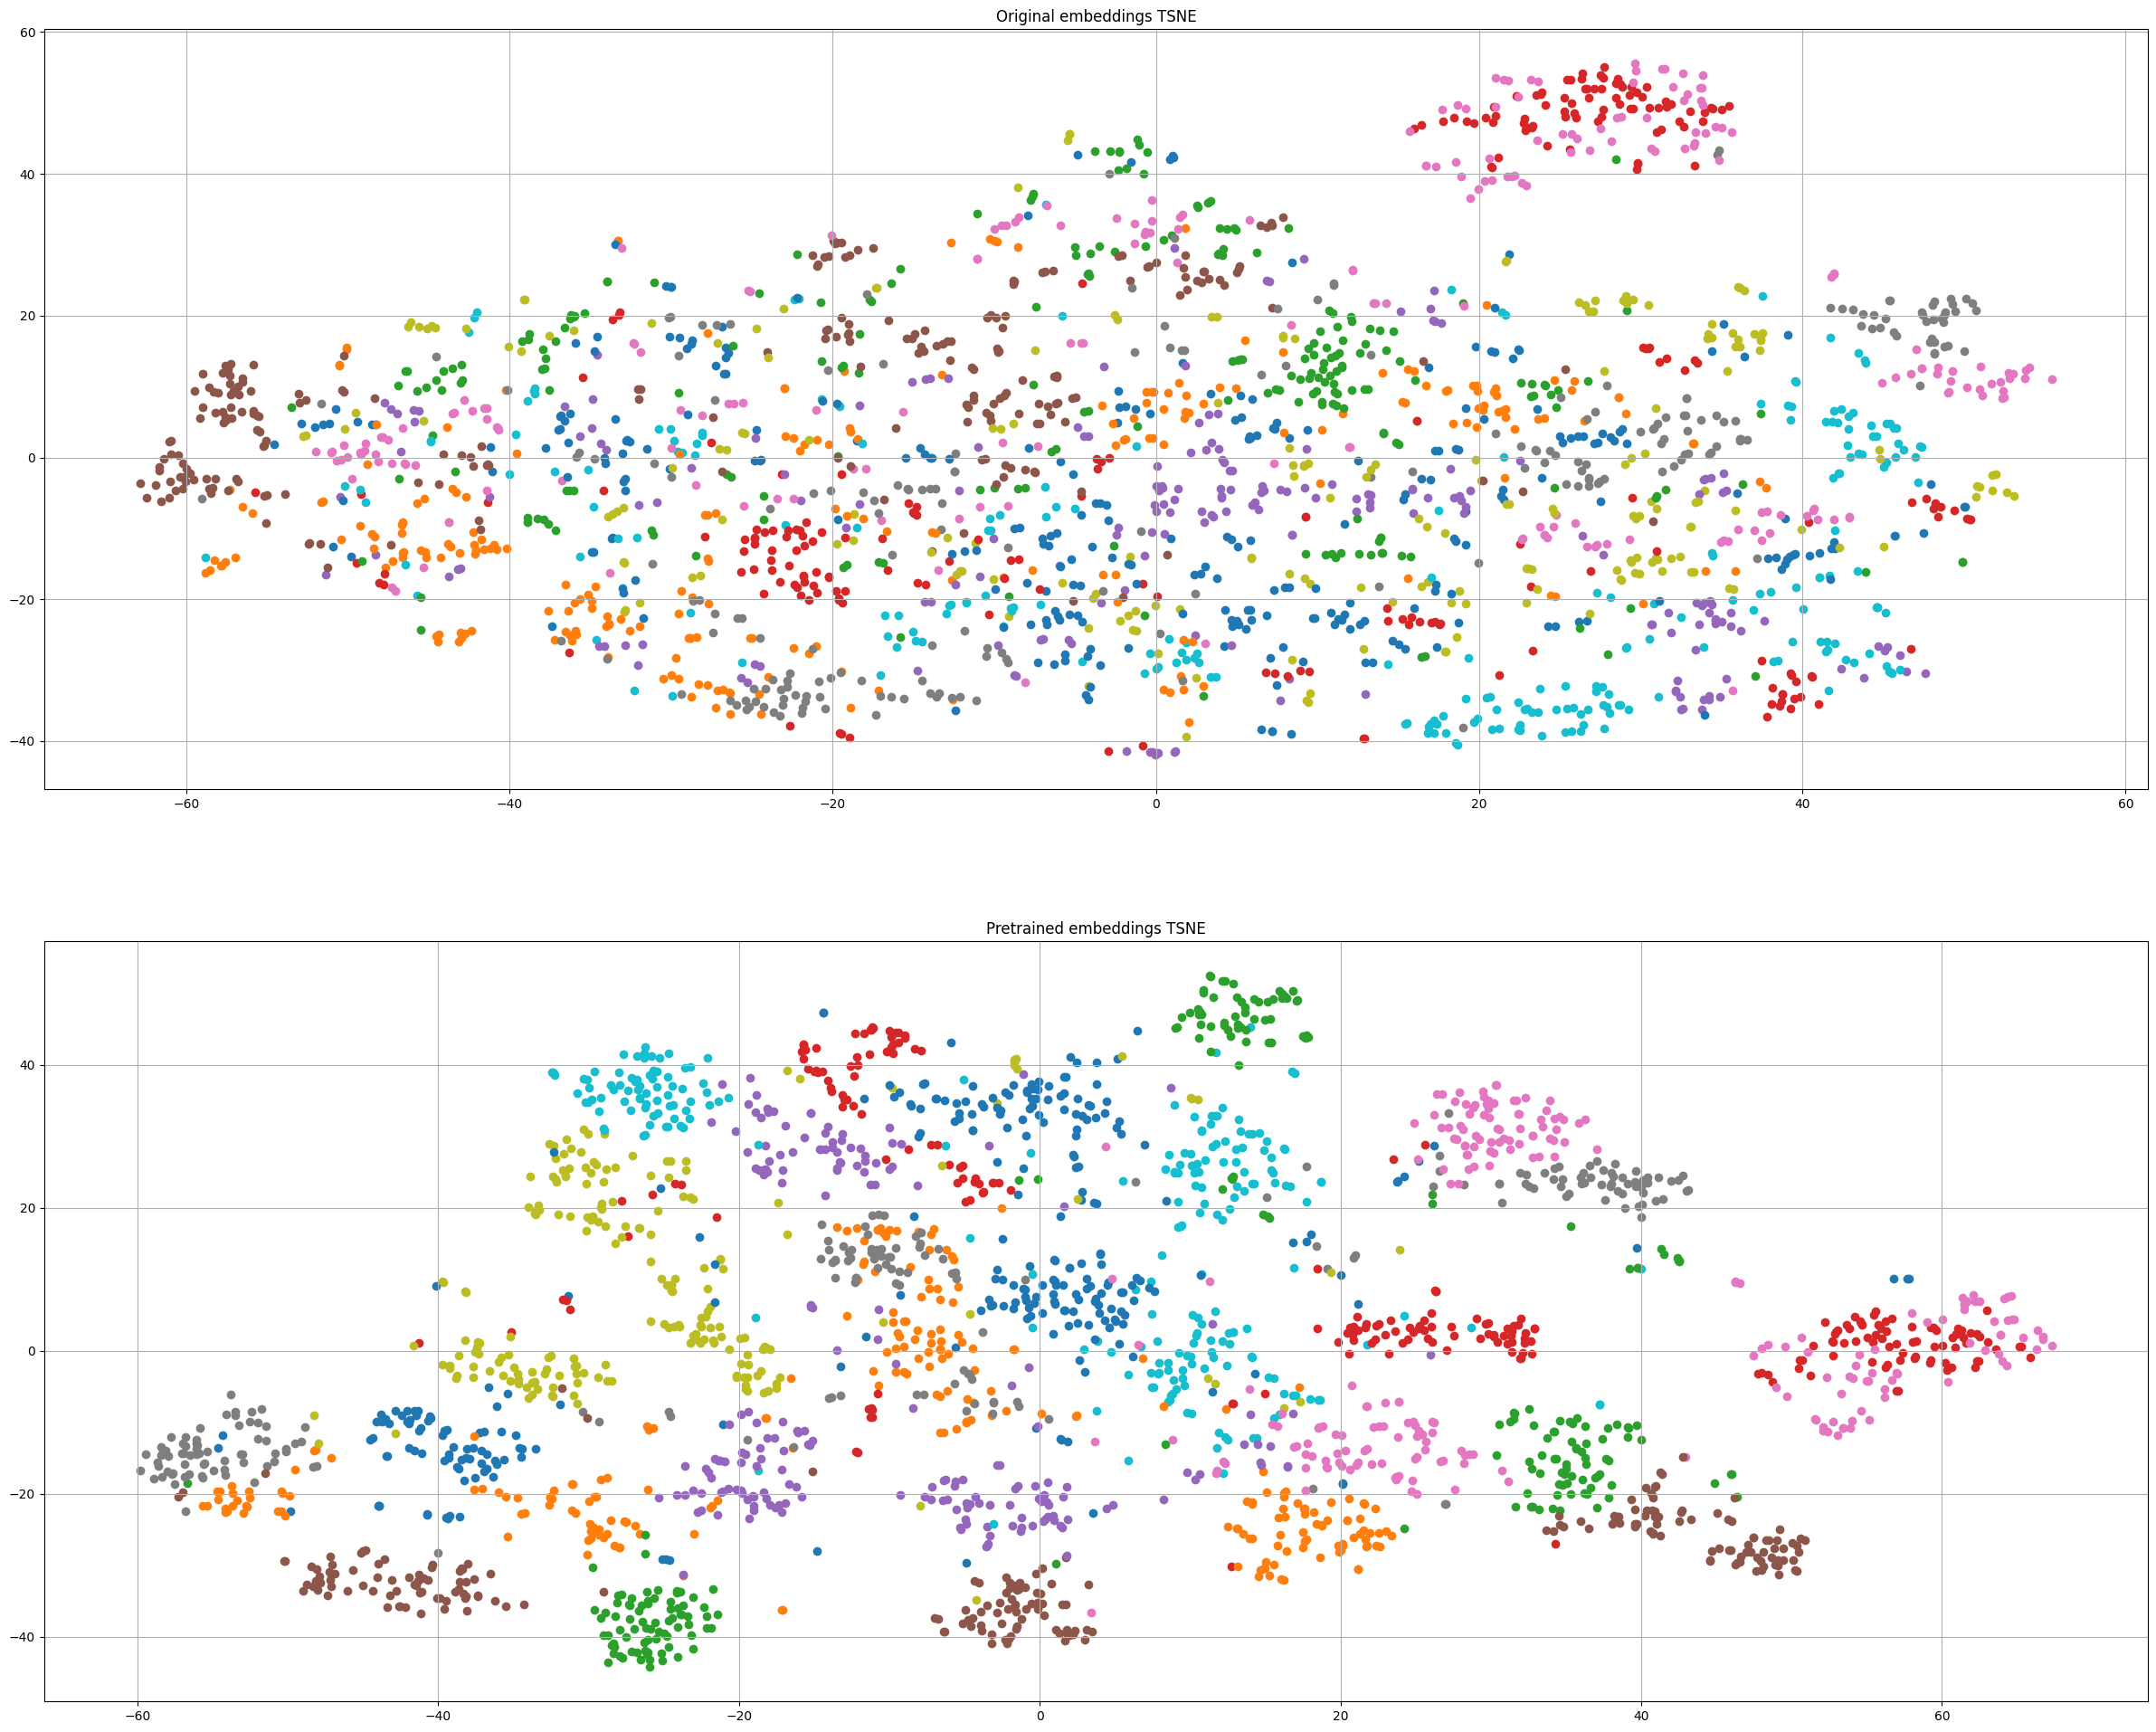

CPU times: user 1min 8s, sys: 656 ms, total: 1min 9s
Wall time: 18 s


In [34]:
%%time
plt.figure(figsize=(30,24))

tsne = TSNE()
train_classes_indexes = get_indexes_of_samples(unseen_test_df['targets'].tolist())

tsne_original_bert_val_emb = tsne.fit_transform(unseen_test_embeddings.cpu())
tsne_pretrained_bert_val_emb = tsne.fit_transform(new_unseen_test_embeddings.cpu())


plt.subplot(2, 1, 1), plt.title('Original embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_original_bert_val_emb[val, 0], y=tsne_original_bert_val_emb[val, 1], label=key)

plt.subplot(2, 1, 2), plt.title('Pretrained embeddings TSNE'), plt.grid()
for key, val in train_classes_indexes.items():
    plt.scatter(x=tsne_pretrained_bert_val_emb[val, 0], y=tsne_pretrained_bert_val_emb[val, 1], label=key)

plt.show()

### Снижение размерности

Существует инжинерный прием для снижения размерности эмбеддингов без дообучения. 

Прием выглядит следующим образом: имея метрические эмбеддинги можно применить к ним линейное преобразование, по сути `torch.nn.Linear(in_features, out_features)`, где `in_features` -- размерность исходного пространства, а `out_features` -- желаемая размерность до которой хотим понизить. В качестве параметров weight этого линейного слоя можно оставить (что самое удивительное) рандомную инициализацию.


Как проверить качество новых эмбеддингов? Вернемся к исходной постановке задачи metric learning, напомним определение многообразия:
* Многообразие (manifold) -- это топологическое пространство с введеным набором карт и координат. Каждой карте (подмножеству многообразия) ставится в соответствие "координаты", то есть такая функция, которая переводит объект из карты в вектор из $R^n$. Примером data manifold из машинного обучения может служить датасет из картинок, все карты в котором будут тождественно равны друг другу и совпадать с открытым покрытием топологического пространства, а координатами будут различные функции перевода картинок в $R^n$, например развертка пикселей в вектор.
Важное уточнение: в топологическом пространстве не определено как таковое понятие расстояния.

Целью metric learning является обучение такой параметрической функции $F_{\Theta}: R^M -> R^N$, которая ставит в соответствие семантически близким объектам из Data Manifold, близкие по дистанции вектора из $R^N$. В качестве дистанции может выступать эвклидово расстояние.

В данных обозначениях, параметрическое линейное преобразование снижения размерности можно представить как $G_{\Lambda}: R^N - R^K$

#### Как проверить качество эмбеддингов после снижения размерности?
Не каждое линейное преобразование будет сохранять относительные расстояние между произольными точками (подробнее см курс линейной алгебры). Наша цель состоит в том, чтобы проверить ту степень, с которой абстрактное линейное (или даже нелинейное) преобразование сохранит относительны расстояния. 
Для этого будем пользоваться неравенством треугольника. Возьмем три случайных объекта из data manifold и соответствующие им координаты из $R^M$, после применения функции $F_{\Theta}$ получим векторное представление этих объектов, назовем эти три точки (вектора)
$A$, $B$, $C$ соответственно. Положим, что после применения $G_{\Lambda}$ они перешли в точки $A'$, $B'$, $C'$. Без ограничения общности (так как мы всегда можем занумеровать точки от бОльшей к мЕньшей) положим, что длины отрезков следующие: $AB \geq BC \geq AC$. 
И нам необходимо проверить, что $A'B' \geq B'C' \geq A'C'$. Данное условие можно переписать так:
1. $(AB - BC)(A'B' - B'C') > 0$
2. $(AB - AC)(A'B' - A'C') > 0$
3. $(BC - AC)(B'C' - A'C') > 0$

Введем метрику, равную количеству треугольников для которых данное неравенство выполнено по отношению к количеству треугольников, для которых оно не выполнено и назовем ее `triangle-keept-ratio`.

Далее в ноутбуке будут продемонстрированы результаты снижения качества метрик для различных условий. В качестве демонстраций будут использованы метрические эмбеддинги из нейросети `clip`.


<!-- #### Количество сохраненной информации после сжатия -->



In [36]:
!pip install clip

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Created wheel for clip: filename=clip-0.2.0-py3-none-any.whl size=7034 sha256=b2fecaa5a82899762e517029b3ecfb5c0061b23eec2687ff86e623911943696b
  Stored in directory: /home/somov-od/.cache/pip/wheels/6d/17/18/6193c6b02f9e35e3b3f0721a349b9f9f74bac11feb0f86fdd1
Successfully built clip


In [45]:
!pip install git+https://github.com/openai/CLIP.git

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-u3u7gwb7
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-u3u7gwb7
     |████████████████████████████████| 53 kB 904 kB/s eta 0:00:011
     |████████████████████████████████| 33.8 MB 2.3 MB/s eta 0:00:01
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369393 sha256=c754f090fb1d9a6034945d09392c530feca8db59bfcc29422abeea1a9c012ec9
  Stored in directory: /tmp/pip-ephem-wheel-cache-awfwys5t/wheels/ab/4f/3a/5e51521b55997aa6f0690e095c08824219753128ce8d9969a3
Successfully built clip
ERROR: torchvision 0.15.1 has requirement torch==2.0.0, but you'll have t

In [46]:
clip.load

<function clip.clip.load(name: str, device: Union[str, torch.device] = 'cuda', jit: bool = False, download_root: str = None)>

In [48]:
import clip

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, texts):
        self.texts = texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        sample = self.texts[idx]
        try:
            tokenized_tensor = clip.tokenize([sample])
        except RuntimeError:
            print("error")
            tokenized_tensor = clip.tokenize(["error"])
        return tokenized_tensor, sample


model, preprocess = clip.load("RN50", device=dev, jit=False)
model.eval()
model = model.to(dev)

In [72]:
from copy import deepcopy


def get_embeddings(out_dim: int, loader):
    # model.eval()
    if out_dim is not None:
        torch.manual_seed(42)
        layer = torch.nn.Linear(in_features=1024, out_features=out_dim, bias=False).to(
            dev
        ).to(torch.float16)

    torch.cuda.empty_cache()
    original_embeddings = []
    reducted_embeddings = []
    for batch in tqdm(
        loader,
        desc="Predicting caption embeddings",
    ):
        with torch.no_grad():
            tokens, _ = batch
            original = model.encode_text(tokens.squeeze().to(dev))
            if out_dim is not None:
                reducted = layer(original)
                reducted_embeddings.append(reducted.detach().cpu())
        original_embeddings.append(original.detach().cpu())

    if out_dim is None:
        reducted_embeddings = deepcopy(original_embeddings)

    original_embeddings = torch.cat(original_embeddings, dim=0)
    reducted_embeddings = torch.cat(reducted_embeddings, dim=0)
    return original_embeddings, reducted_embeddings


def _l2_distance(_a: torch.Tensor, _b: torch.Tensor) -> float:
    _dist = (_a - _b).pow(2).sum(0)
    return float(_dist.detach().cpu())


def check_random_triangle(original_embeddings, reducted_embeddings):
    i, j, k = np.random.uniform(low=0, high=len(original_embeddings), size=3).astype(
        int
    )
    ab, bc, ac = [
        _l2_distance(original_embeddings[first], original_embeddings[second])
        for (first, second) in zip((i, j, k), (j, k, i))
    ]
    ab_, bc_, ac_ = [
        _l2_distance(reducted_embeddings[first], reducted_embeddings[second])
        for (first, second) in zip((i, j, k), (j, k, i))
    ]
    flag = True
    flag &= (ab - ac) * (ab_ - ac_) > 0
    flag &= (ab - bc) * (ab_ - bc_) > 0
    flag &= (bc - ac) * (bc_ - ac_) > 0
    return flag


def check_embeddings_quality(out_dim: int, tries: int = 8_192):
    train_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(list(train_df["intents"])),
        batch_size=128,
        num_workers=0,
        shuffle=False,
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(list(val_df["intents"])),
        batch_size=128,
        num_workers=0,
        shuffle=False,
    )
    seen_test_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(list(seen_test_df["intents"])),
        batch_size=128,
        num_workers=0,
        shuffle=False,
    )
    unseen_test_loader = torch.utils.data.DataLoader(
        dataset=MyDataset(list(unseen_test_df["intents"])),
        batch_size=128,
        num_workers=0,
        shuffle=False,
    )
    train_original_embeddings, train_reducted_embeddings = get_embeddings(
        out_dim=out_dim, loader=train_loader
    )
    val_original_embeddings, val_reducted_embeddings = get_embeddings(
        out_dim=out_dim, loader=val_loader
    )
    seen_test_original_embeddings, seen_test_reducted_embeddings = get_embeddings(
        out_dim=out_dim, loader=seen_test_loader
    )
    unseen_test_original_embeddings, unseen_test_reducted_embeddings = get_embeddings(
        out_dim=out_dim, loader=unseen_test_loader
    )

    total, hits = 0, 0
    for _ in tqdm(range(tries)):
        total += 1
        hits += int(
            check_random_triangle(train_original_embeddings, train_reducted_embeddings)
        )
    triangle_keept = hits / total

    new_storage_embeddings = np.concatenate(
        [
            train_reducted_embeddings.cpu().detach().numpy(),
            val_reducted_embeddings.cpu().detach().numpy(),
            seen_test_reducted_embeddings.cpu().detach().numpy(),
        ],
        axis=0,
    ).astype(np.float32)
    classes_array = (
        train_df["targets"].to_list()
        + val_df["targets"].to_list()
        + seen_test_df["targets"].to_list()
    )

    knn_index = KnnIndex(new_storage_embeddings, classes_array)

    preds = []
    targets = list(unseen_test_df["targets"])
    possible_intents = set(list(unseen_test_df["targets"]))
    for query in tqdm(unseen_test_reducted_embeddings.numpy(), desc="Predicting"):
        query = query.astype(np.float32)
        pred_class = knn_index.search_index(np.expand_dims(query, axis=0))
        if pred_class in possible_intents:
            preds.append(pred_class)
        else:
            preds.append("misclassified")

    assert len(preds) == len(targets)
    qual = classification_report(preds, targets, output_dict=True)
    f1_mean = qual["macro avg"]["f1-score"]
    recall_mean = qual["macro avg"]["recall"]
    precision_mean = qual["macro avg"]["precision"]
    return {
        "triangle-keept-ratio": triangle_keept,
        "f1_mean": f1_mean,
        "recall_mean": recall_mean,
        "precision_mean": precision_mean,
    }

In [64]:
np.float32

numpy.float32

In [73]:
check_embeddings_quality(out_dim=32)

Predicting: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2325/2325 [00:01<00:00, 1735.46it/s]


{'triangle-keept-ratio': 0.3724365234375,
 'f1_mean': 0.7700165894243107,
 'recall_mean': 0.9251523905383088,
 'precision_mean': 0.6742211509657454}

In [74]:
results = dict()
dims = [None, 768, 512, 384, 256, 189, 128, 96, 64, 48, 32, 24, 16, 12, 8, 6, 4, 3, 2]
for dim in dims:
    results[dim if dim is not None else 1024] = check_embeddings_quality(out_dim=dim)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8192/8192 [00:01<00:00, 4305.77it/s]


Predicting caption embeddings:  34%|███████████████████████████████████████████████████████▊                                                                                                           | 39/114 [00:04<00:07,  9.74it/s]


KeyboardInterrupt: 

In [75]:
results

{1024: {'triangle-keept-ratio': 0.9937744140625,
  'f1_mean': 0.841830861496488,
  'recall_mean': 0.9388786444411216,
  'precision_mean': 0.7749940254597084},
 768: {'triangle-keept-ratio': 0.744384765625,
  'f1_mean': 0.8417410915334163,
  'recall_mean': 0.9420712824716331,
  'precision_mean': 0.7740849503253704},
 512: {'triangle-keept-ratio': 0.693359375,
  'f1_mean': 0.840631706671046,
  'recall_mean': 0.9410173519212427,
  'precision_mean': 0.7723453009124455},
 384: {'triangle-keept-ratio': 0.6707763671875,
  'f1_mean': 0.8343117241753681,
  'recall_mean': 0.939607716455182,
  'precision_mean': 0.7631911909786937},
 256: {'triangle-keept-ratio': 0.6097412109375,
  'f1_mean': 0.8381290156981341,
  'recall_mean': 0.941796308206637,
  'precision_mean': 0.7671369102817852},
 189: {'triangle-keept-ratio': 0.5755615234375,
  'f1_mean': 0.8346003322497288,
  'recall_mean': 0.938650915999611,
  'precision_mean': 0.7637335492759851},
 128: {'triangle-keept-ratio': 0.5169677734375,
  'f1_m

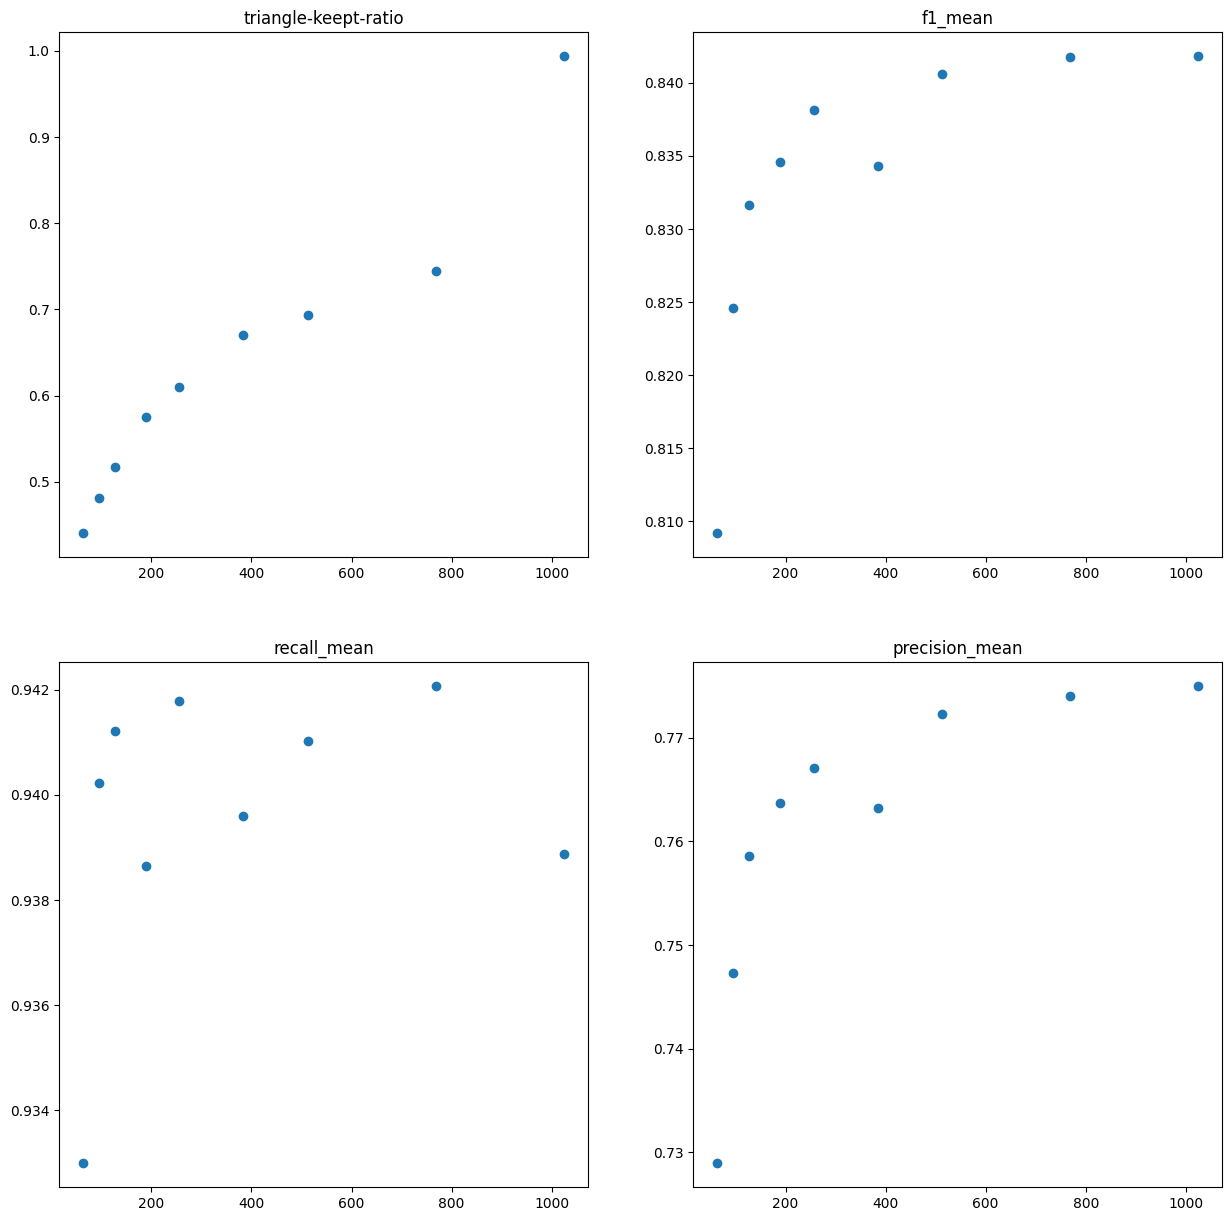

In [76]:
metrics = {key: [el[key] for el in results.values()] for key in results[1024].keys()}
fig, _axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
axs = [item for sublist in _axs for item in sublist]
for ax, metric_name in zip(axs, metrics.keys()):
    values = metrics[metric_name]
    ax.scatter(list(results.keys()), values)
    ax.set_title(metric_name)

In [77]:
unseen_test_loader = torch.utils.data.DataLoader(
    dataset=MyDataset(list(unseen_test_df["intents"])),
    batch_size=128,
    num_workers=0,
    shuffle=False,
)

unseen_test_original_embeddings, _ = get_embeddings(
    out_dim=None, loader=unseen_test_loader
)

Predicting caption embeddings: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:01<00:00,  9.91it/s]


Text(0.5, 1.0, 'Clip embeddings')

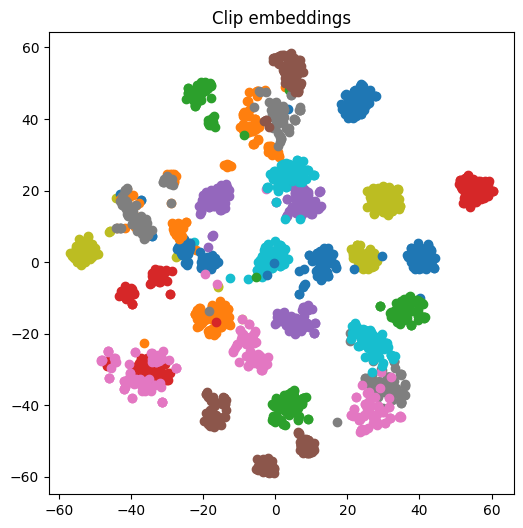

In [78]:
# %%time
tsne = TSNE()
tsne_original_val_emb = tsne.fit_transform(unseen_test_original_embeddings.detach().cpu())
val_classes_indexes = get_indexes_of_samples(unseen_test_df["targets"].values)

plt.figure(figsize=(6, 6))
for key, val in val_classes_indexes.items():
    plt.scatter(
        x=tsne_original_val_emb[val, 0], y=tsne_original_val_emb[val, 1], label=key
    )
plt.title('Clip embeddings')